<a href="https://colab.research.google.com/github/mzkhan2000/MLinTensorflow/blob/FakeNewsDetectionbyTF/The_tensorflow_version_magic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TensorFlow versions in Colab

In [1]:
#Importing the required Libraries
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')
print("Tensorflow version " + tf.__version__)


Tensorflow version 2.4.1


In [4]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of accelerators:  1


In [10]:
from google.colab import files
data_to_load = files.upload()

Saving Fake.csv to Fake.csv


In [13]:
from google.colab import files
data_to_load_true = files.upload()

Saving True.csv to True.csv


In [16]:
import io
fake_df = pd.read_csv(io.BytesIO(data_to_load['Fake.csv']))

In [21]:
import io
real_df = pd.read_csv(io.BytesIO(data_to_load_true['True.csv']))

In [22]:
fake_df.isnull().sum()
real_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [23]:
fake_df.subject.unique()
real_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [26]:
fake_df.drop(['date', 'subject'], axis=1, inplace=True)
real_df.drop(['date', 'subject'], axis=1, inplace=True)

KeyError: ignored

In [27]:
fake_df['class'] = 0 
real_df['class'] = 1

Text(0, 0.5, '# of News Articles')

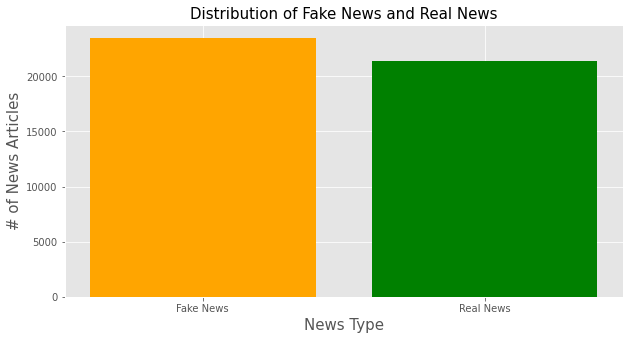

In [28]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='orange')
plt.bar('Real News', len(real_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)

In [29]:
print('Difference in news articles:',len(fake_df)-len(real_df))

Difference in news articles: 2064


In [30]:
news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
news_df

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1


In [31]:
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

In [32]:
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [33]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [34]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [35]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [36]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 390,401
Trainable params: 390,401
Non-trainable params: 0
__________________________________________________

In [38]:
# We are going to use early stop, which stops when the validation loss no longer improve.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1078/1078 [==============================] - 441s 403ms/step - loss: 0.4530 - accuracy: 0.7230 - val_loss: 0.0753 - val_accuracy: 0.9791
Epoch 2/10
1078/1078 [==============================] - 438s 406ms/step - loss: 0.0633 - accuracy: 0.9835 - val_loss: 0.0368 - val_accuracy: 0.9864
Epoch 3/10
1078/1078 [==============================] - 438s 407ms/step - loss: 0.0320 - accuracy: 0.9924 - val_loss: 0.0378 - val_accuracy: 0.9861
Epoch 4/10
1078/1078 [==============================] - 443s 411ms/step - loss: 0.0186 - accuracy: 0.9963 - val_loss: 0.0494 - val_accuracy: 0.9827


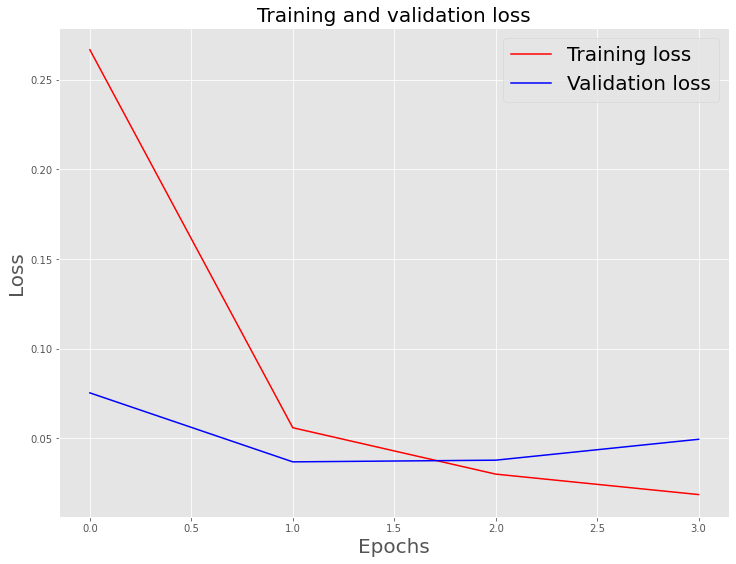

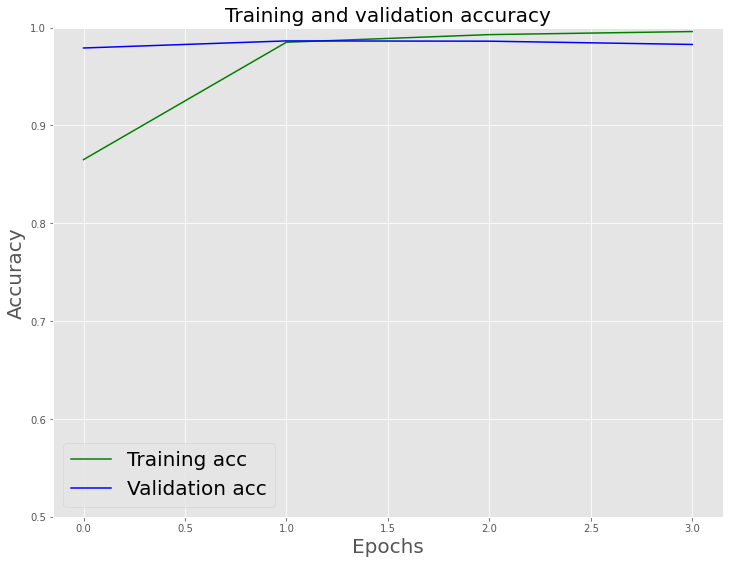

In [39]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [40]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 25s 88ms/step - loss: 0.0425 - accuracy: 0.9872


[0.04245918616652489, 0.987193763256073]

In [41]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [42]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9871937639198218
Precision on testing set: 0.983788791106994
Recall on testing set: 0.989517819706499


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

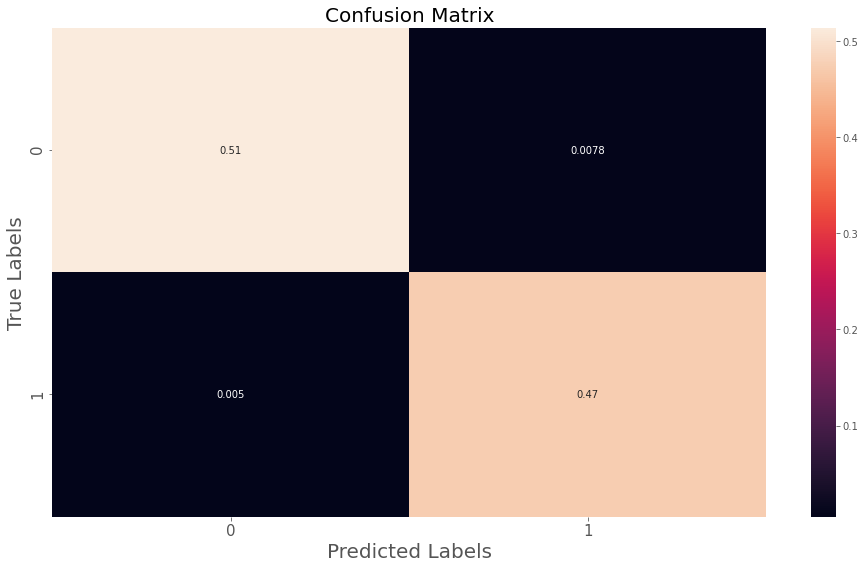

In [43]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

In [44]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 32)


In [45]:
word_index = list(tokenizer.word_index.keys())
word_index = word_index[:max_vocab-1]


##Background
Colab has two versions of TensorFlow pre-installed: a 2.x version and a 1.x version. Colab uses TensorFlow 2.x by default, though you can switch to 1.x by the method shown below.


##Specifying the TensorFlow version

Running `import tensorflow` will import the default version (currently 2.x). You can use 1.x by running a cell with the `tensorflow_version` magic **before** you run `import tensorflow`.

In [14]:
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


Once you have specified a version via this magic, you can run `import tensorflow` as normal and verify which version was imported as follows:

In [15]:
import tensorflow
print(tensorflow.__version__)

2.4.1


If you want to switch TensorFlow versions after import, you **will need to restart your runtime** with 'Runtime' -> 'Restart runtime...' and then specify the version before you import it again.

## Avoid Using ``pip install`` with GPUs and TPUs

We recommend against using ``pip install`` to specify a particular TensorFlow version for both GPU and TPU backends. Colab builds TensorFlow from source to ensure compatibility with our fleet of accelerators. Versions of TensorFlow fetched from PyPI by ``pip`` may suffer from performance problems or may not work at all.